In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline


In [22]:
# Camera Calibration Section

cal_images = os.listdir('camera_cal/')
#print(cal_images.shape)
objpoints = []
imgpoints = []
nx = 9
ny = 6
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
for image in cal_images:
    img = mpimg.imread('camera_cal/'+image)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if (ret == True):
        imgpoints.append(corners)
        objpoints.append(objp)


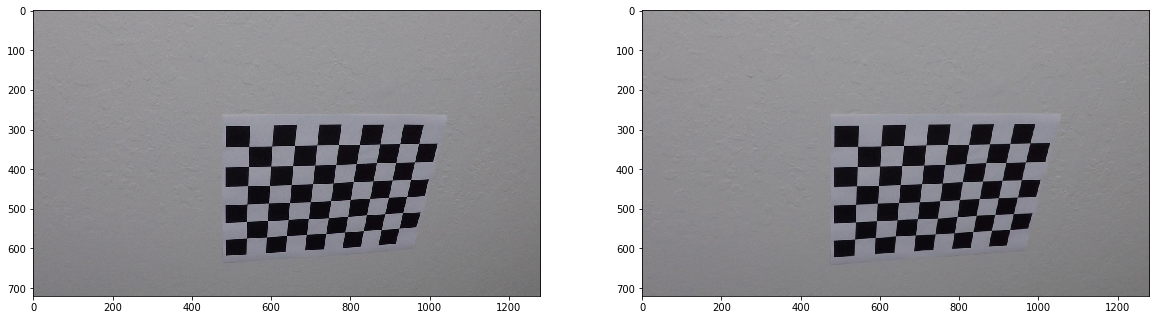

In [23]:
def undistort(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

fig = plt.figure(figsize = (20,40))
#test_images = os.listdir('test_images/')
image = mpimg.imread('camera_cal/' + cal_images[0])
im1 = fig.add_subplot(1,2,1)
im1.imshow(image)
undistorted = undistort(image)
im2 = fig.add_subplot(1,2,2)
im2.imshow(undistorted)

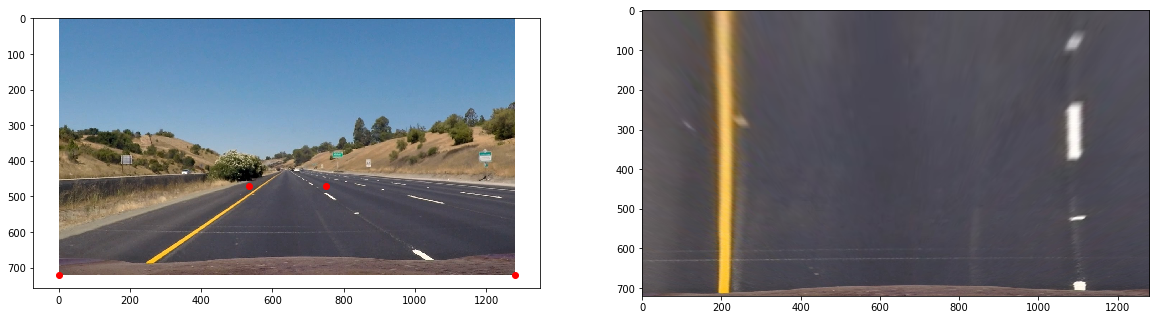

In [24]:
#src = np.float32([[545,470],[750, 470],
#                      [60, 720],[1280, 720]])
src = np.float32([[533,470],[750, 470],
                      [0, 720],[1280, 720]])
dst = np.float32([[0, 0], [1280, 0], 
                     [0, 720],[1280, 720]])

def perspective_transform(img):
    M = cv2.getPerspectiveTransform(src, dst)
    warped_image=cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]), flags = cv2.INTER_LINEAR)
    return warped_image


test_images = os.listdir('test_images/')
image = mpimg.imread('test_images/' + test_images[1])
fig1 = plt.figure(figsize = (20,40))
im1 = fig1.add_subplot(1,2,1)
im1.imshow(image)
im1.scatter(x=[src[0][0], src[1][0], src[2][0], src[3][0]], y=[src[0][1], src[1][1], src[2][1], src[3][1]], c='r')
#im1.show()
im2 = fig1.add_subplot(1,2,2)
image = undistort(image)
p_image = perspective_transform(image)
im2.imshow(p_image)

(720, 1280)
(720, 1280)
(720, 1280)


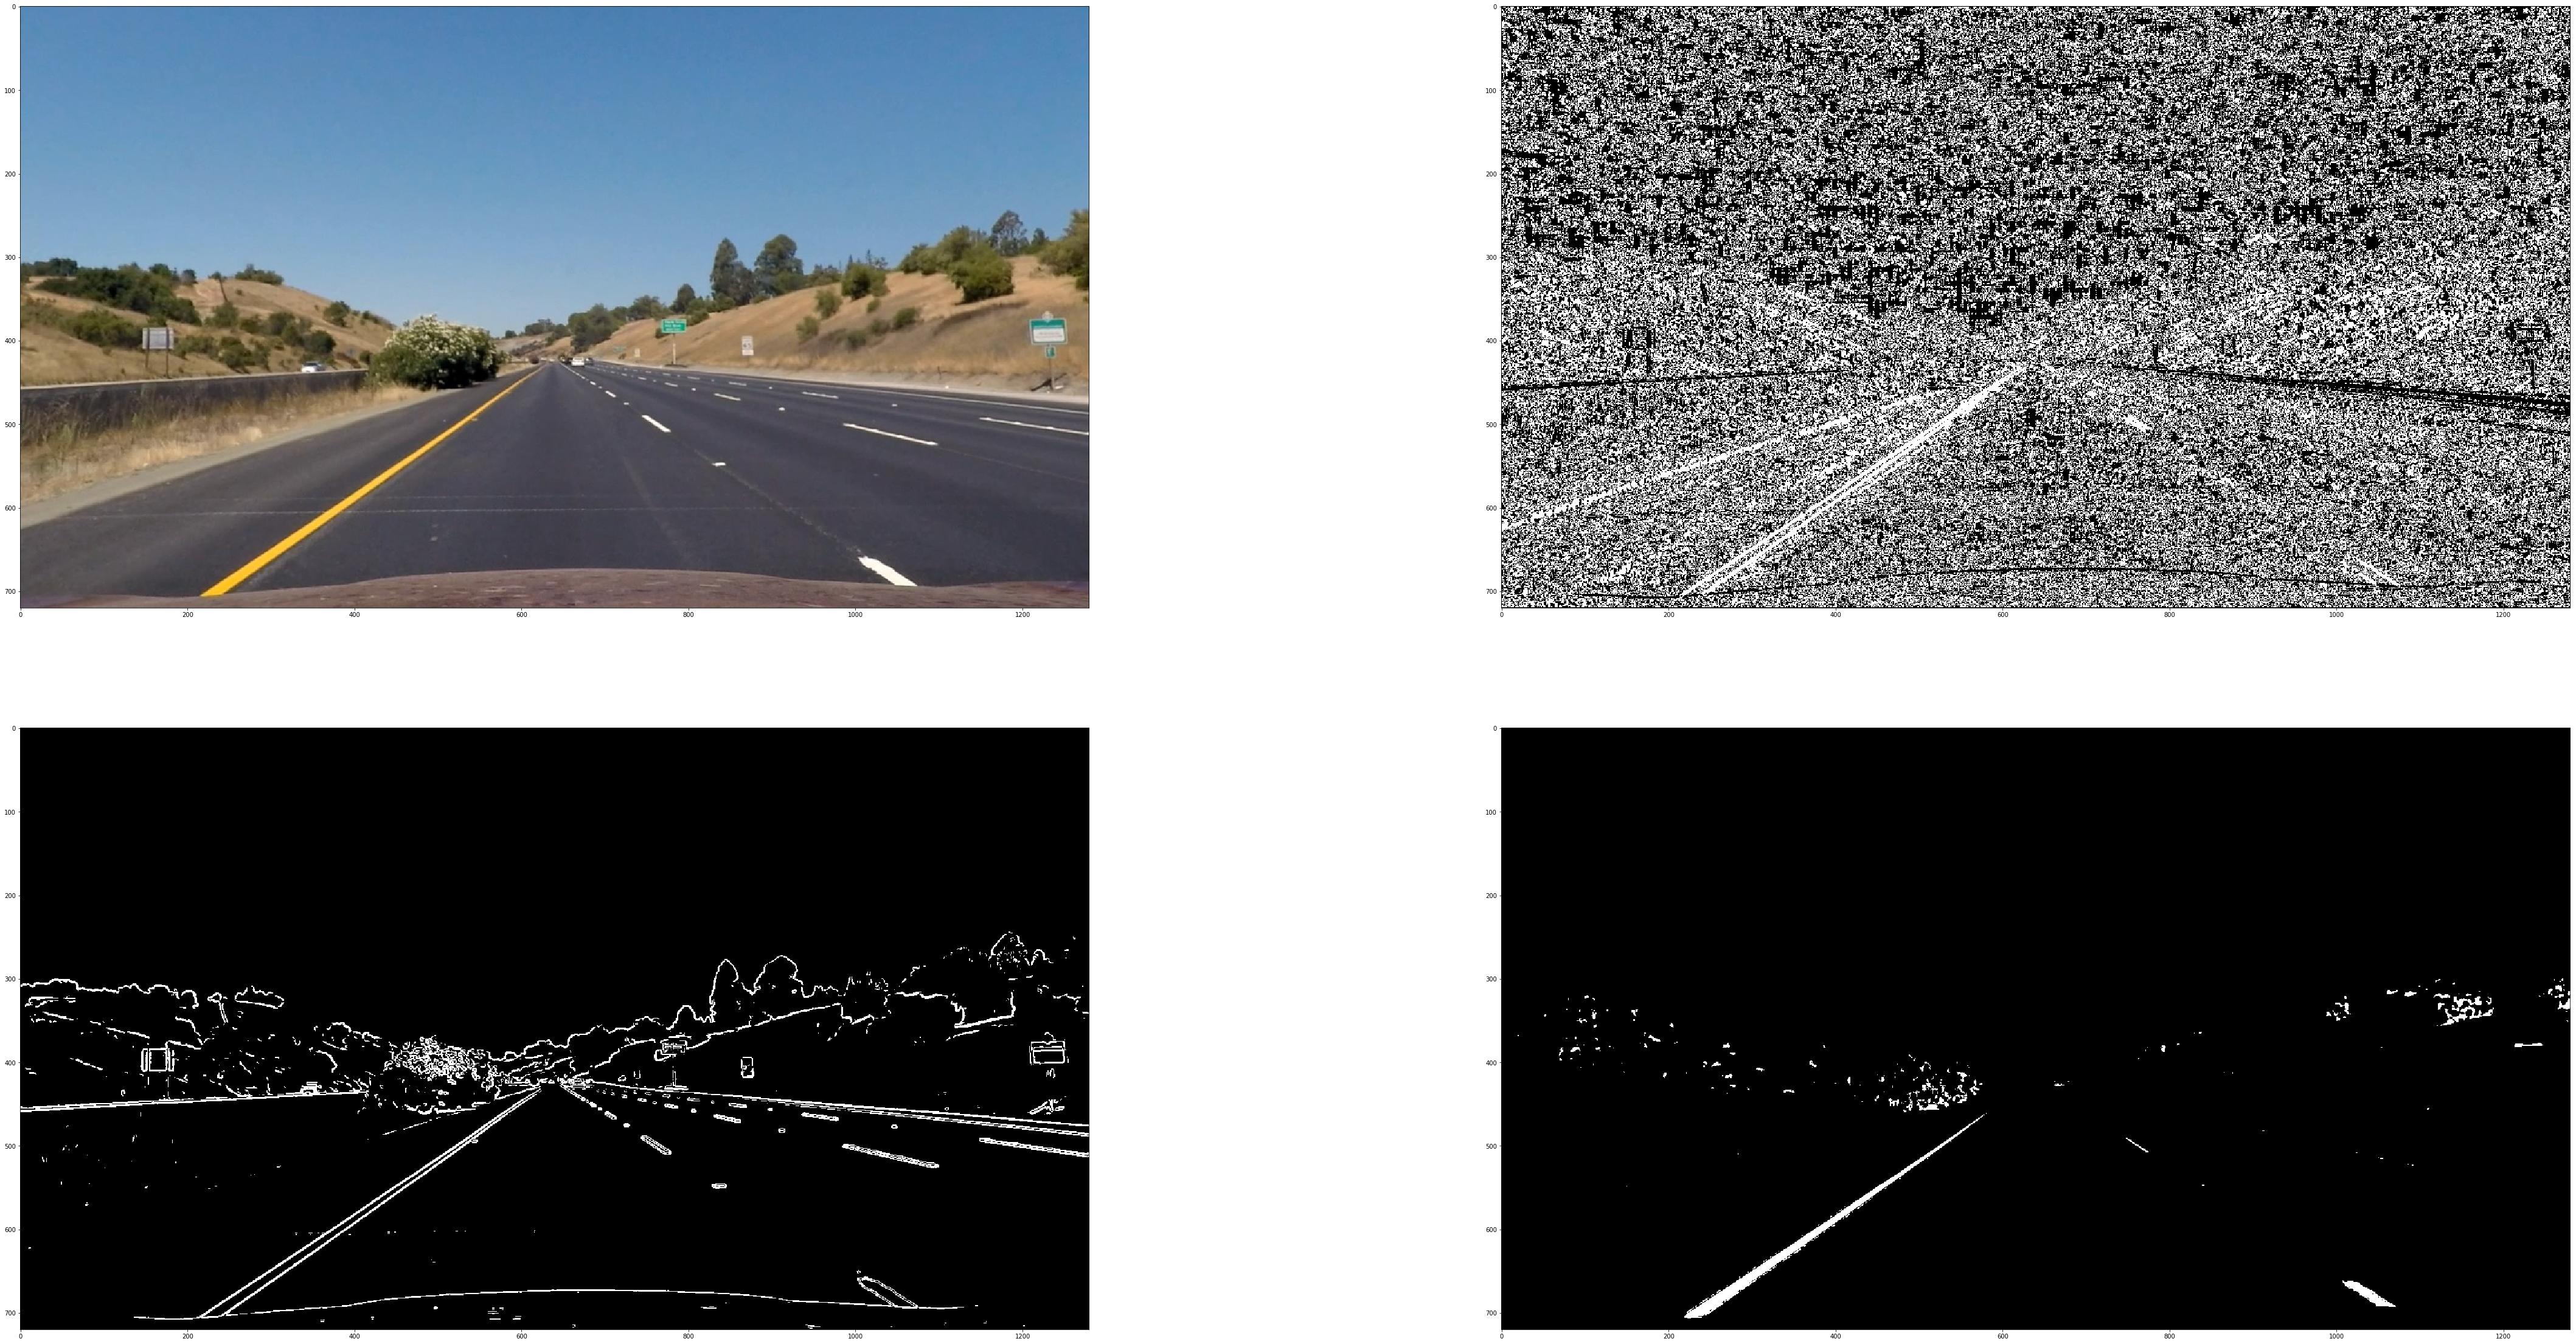

In [27]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    #print(binary_output.shape)

    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    #print(binary_output.shape)

    return binary_output

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    #print(binary_output.shape)

    return binary_output

fig2 = plt.figure(figsize = (80,40))
im1 = fig2.add_subplot(2,2,1)
im1.imshow(image)

im2 = fig2.add_subplot(2,2,2)
dir_image = dir_threshold(image, thresh=(3*np.pi/16, 7*np.pi/16))
im2.imshow(dir_image, cmap = 'gray')

im3 = fig2.add_subplot(2,2,3)
mag_image = mag_thresh(image, mag_thresh=(50, 200))
im3.imshow(mag_image, cmap = 'gray')

im4 = fig2.add_subplot(2,2,4)
hls_image = hls_select(image, thresh=(150, 255))
im4.imshow(hls_image, cmap = 'gray')

print(dir_image.shape)
print(mag_image.shape)
print(hls_image.shape)

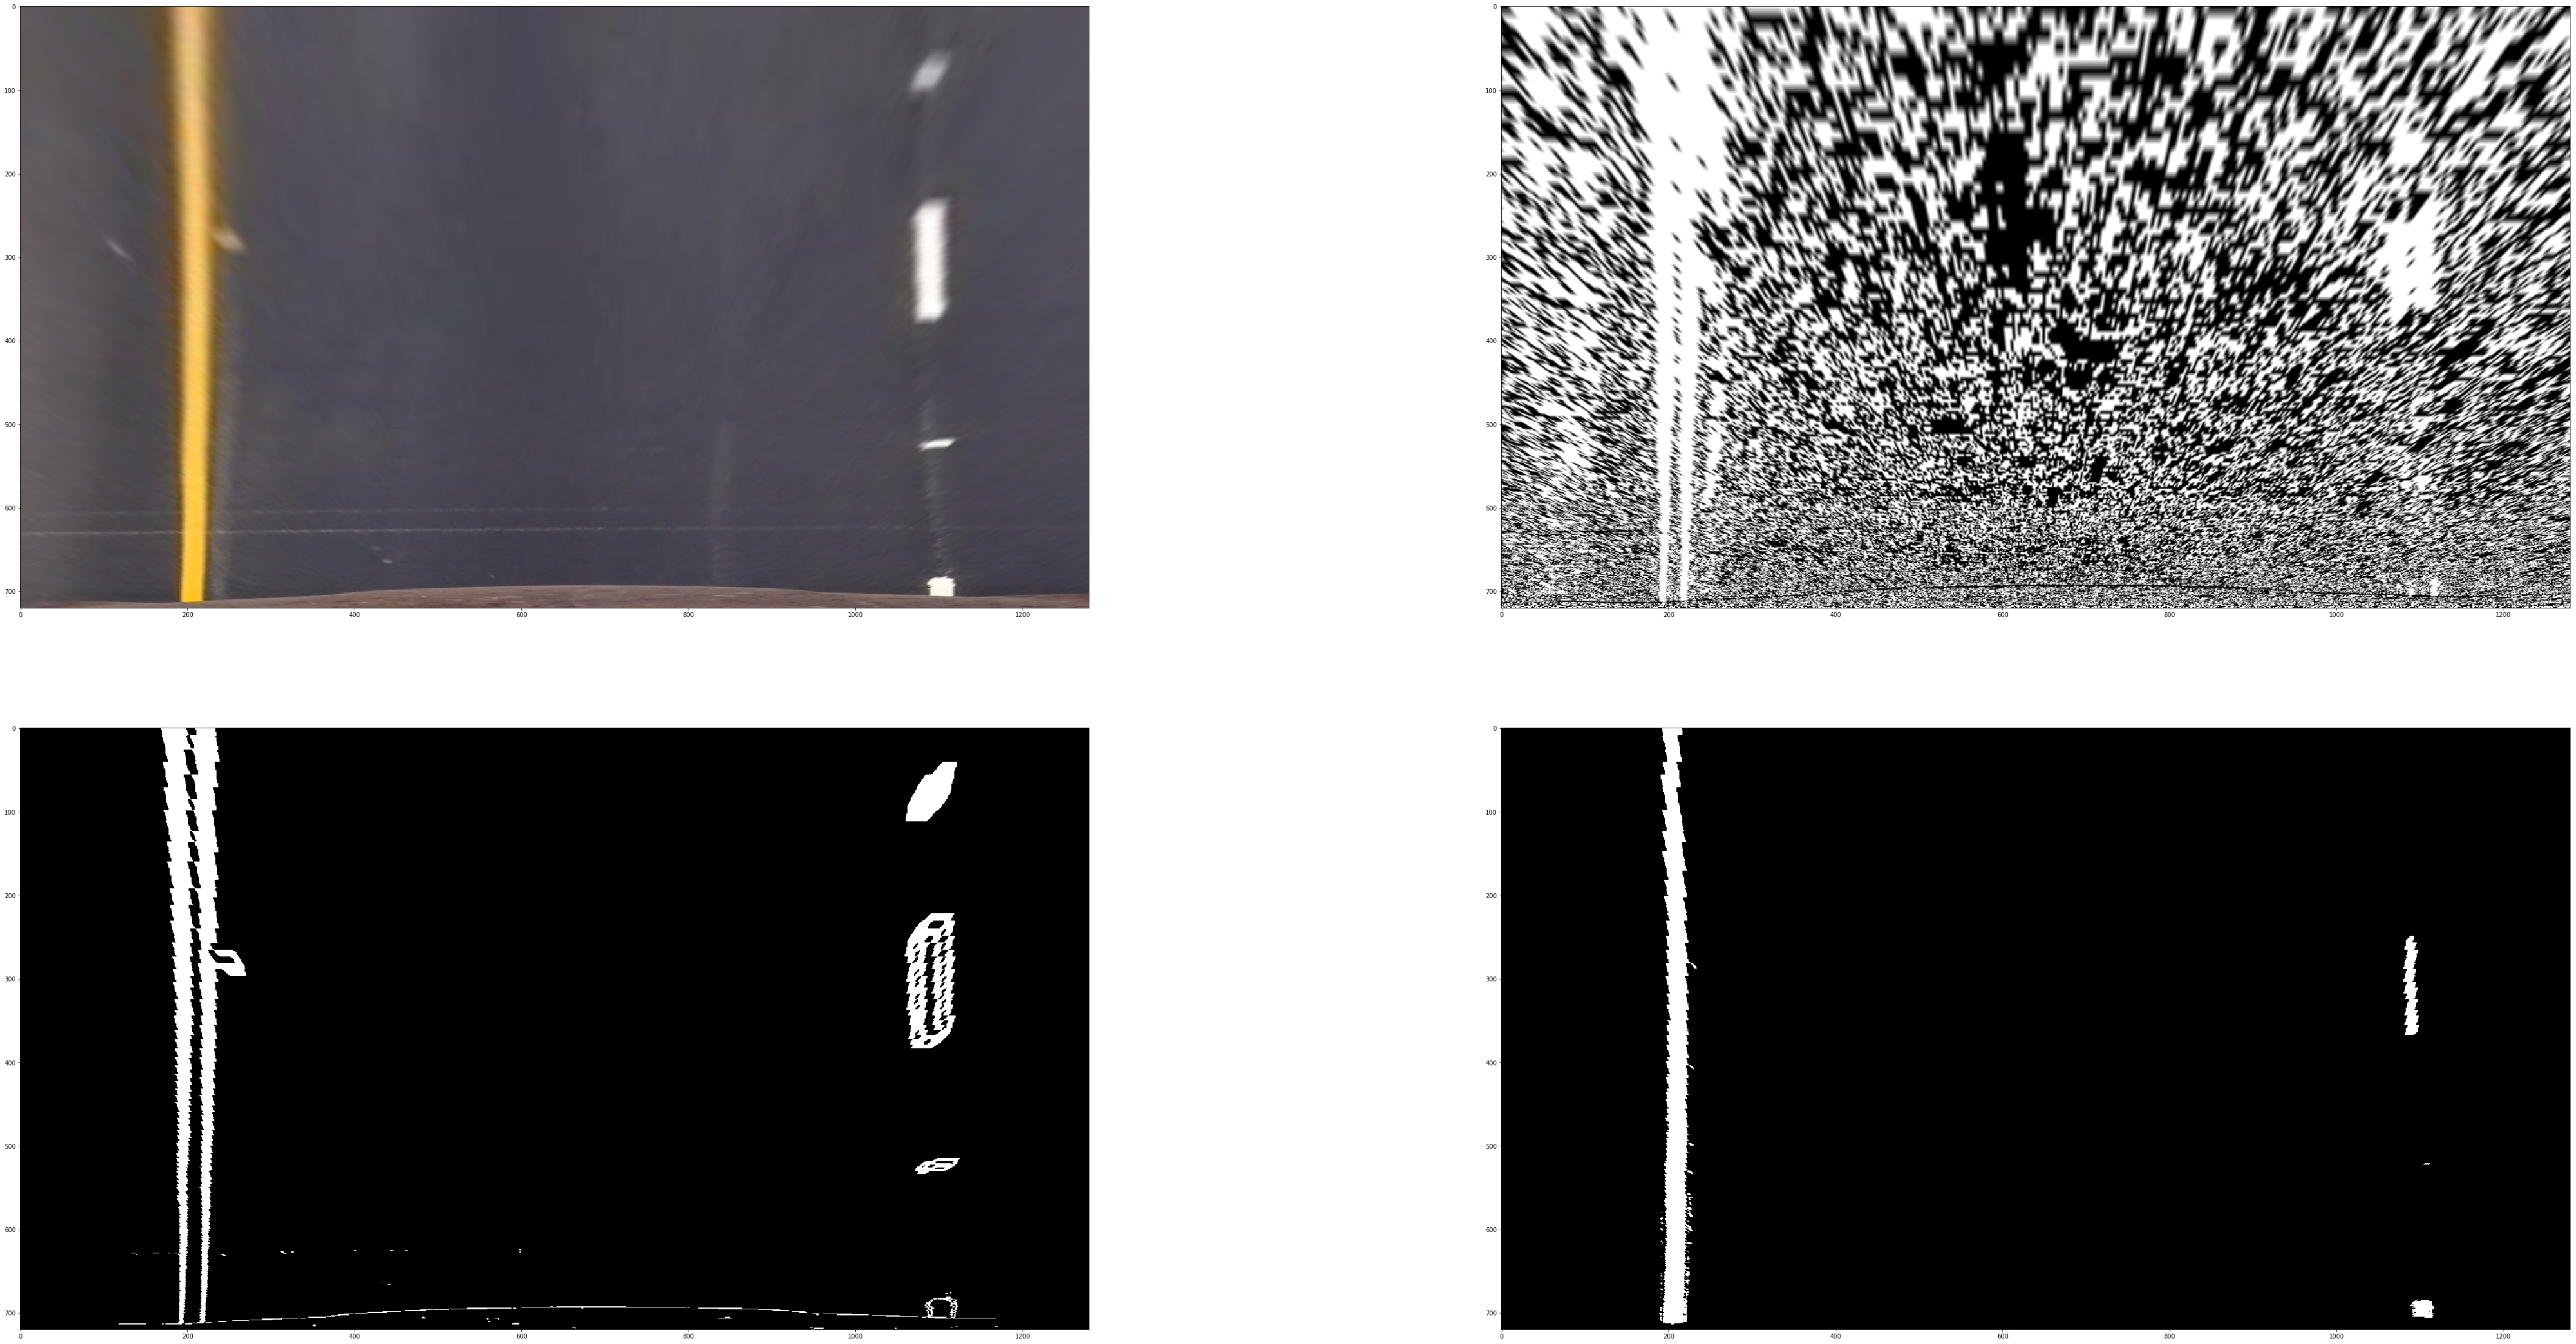

In [26]:
fig2 = plt.figure(figsize = (80,40))
im1 = fig2.add_subplot(2,2,1)
p_image = perspective_transform(image)
im1.imshow(p_image)

im2 = fig2.add_subplot(2,2,2)
dir_image_p = perspective_transform(dir_image)
im2.imshow(dir_image_p, cmap = 'gray')

im3 = fig2.add_subplot(2,2,3)
mag_image_p = perspective_transform(mag_image)
im3.imshow(mag_image_p, cmap = 'gray')

im4 = fig2.add_subplot(2,2,4)
hls_image_p = perspective_transform(hls_image)
im4.imshow(hls_image_p, cmap = 'gray')


(720, 1280)


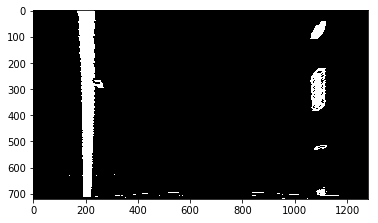

In [28]:
# test combinations
#print((mag_image == 1)&(hls_image == 1))
binary_warped = np.zeros_like(hls_image)
#combined = np.zeros_like(image)
binary_warped[(mag_image_p == 1)|(hls_image_p == 1)] = 255
print(binary_warped.shape)
#binary_warped = perspective_transform(combined)
imf = plt.imshow(binary_warped, cmap = 'gray')
plt.show()

In [30]:
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = int(binary_warped.shape[0]) - (window+1)*window_height
    win_y_high = int(binary_warped.shape[0]) - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    #cv2.rectangle(out_img,(300,0),(580,250),(0,255,0), 2)
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)